In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import Levenshtein
from scipy import stats
import matplotlib
font = {'family' : 'Arial',
        'size'   : 12}

matplotlib.rc('font', **font)

## Corpus

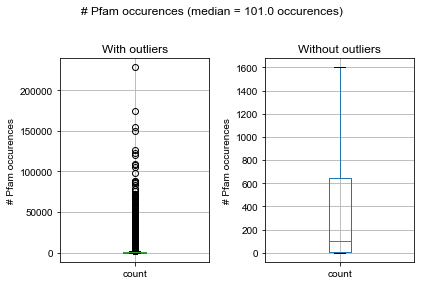

In [3]:
corpus_counts = pd.read_csv('../data/bacteria/corpus/corpus-1e-02.counts.csv').set_index('pfam_id')
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
median = np.median(corpus_counts)
ax = corpus_counts.boxplot(ax=axes[0])
ax.set_ylabel('# Pfam occurences')
ax.set_title('With outliers'.format(median))
ax = corpus_counts.boxplot(showfliers=False, ax=axes[1])
ax.set_ylabel('# Pfam occurences')
ax.set_title('Without outliers')
plt.suptitle('# Pfam occurences (median = {} occurences)'.format(median))
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

In [4]:
len(corpus_counts)

15686

In [19]:
corpus_counts.sum()

count    23425967
dtype: int64

In [20]:
def min_max_norm(df):
    return (df-df.min())/(df.max()-df.min())

def mean_norm(df):
    return (df-df.mean())/df.std()

In [21]:
def load_word2vec(path):
    model = word2vec.load(path, kind='bin')
    idx = pd.Series(model.vocab, name='pfam_id')
    return pd.DataFrame(model.vectors, index=idx)

In [22]:
clans = pd.read_csv('../data/pfam/Pfam-A.clans.csv')
clans = clans.dropna()
print(len(clans['clan_id'].unique()))
clans.head()

604


,pfam_id,clan_id,description
0,PF00001,CL0192,7 transmembrane receptor (rhodopsin family)
1,PF00002,CL0192,7 transmembrane receptor (Secretin family)
2,PF00003,CL0192,7 transmembrane sweet-taste receptor of 3 GCPR
3,PF00004,CL0023,ATPase family associated with various cellular...
4,PF00005,CL0023,ABC transporter


In [23]:
import word2vec
#model = word2vec.load('../data/features/first_pfam2vec/pfam2vec_sg_new_1e-2.bin', kind='bin')
#model = word2vec.load('../data/features/pfam2vec-untrained/pfam2vec_corpus-1e-02_skipgram_100dim.bin', kind='bin')
#model = word2vec.load('../data/features/pfam2vec/pfam2vec_corpus-1e-02_skipgram_100dim.bin', kind='bin')
#vecs = load_word2vec('../data/features/pfam2vec-experiments/iterations/pfam2vec_corpus-1e-02_skipgram_100dim_5win_8iter.bin')
vecs = load_word2vec('../data/features/pfam2vec-experiments/pfam2vec_top.bin')
#vecs = load_word2vec('../data/features/pfam2vec-experiments/pfam2vec_untrained.bin')
vecs.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
pfam_id,,,,,,,,,,,,,,,,,,,,,
</s>,0.143333,0.158255,-0.137158,-0.117384,0.048936,0.108183,0.033691,0.007568,-0.129039,0.079442,...,-0.054848,-0.075464,-0.104101,0.100795,0.056553,0.015217,-0.078551,0.054569,0.109554,0.006934
PF00005,0.045443,-0.035938,0.100785,0.040616,-0.164825,0.073102,0.058317,-0.108120,-0.069214,0.148570,...,-0.182994,0.114296,-0.118334,0.086235,0.099875,-0.009867,-0.118115,0.002825,0.037026,-0.107635
PF13191,0.127100,-0.062958,0.023303,0.051697,-0.137988,0.070571,0.050970,-0.177628,-0.072389,0.043156,...,-0.016578,-0.033136,-0.144379,0.066371,0.125671,0.019653,-0.074900,-0.017191,0.124659,-0.069454
PF13555,0.030957,-0.046982,0.070707,0.028994,-0.104818,0.042575,0.063894,-0.087249,-0.094825,0.191342,...,-0.172500,0.155366,-0.125272,0.087847,0.136480,-0.040163,-0.172234,-0.001175,-0.011556,-0.056780
PF13304,0.048468,-0.076121,0.077691,0.046967,-0.075462,0.050331,0.023607,-0.118182,-0.089822,0.211084,...,-0.216960,0.118862,-0.132330,0.125606,0.048127,-0.038995,-0.155338,0.034605,-0.060200,-0.006745


In [24]:
#vecs.to_csv('../data/features/evaluation/pfam2vec_corpus-1e-02_skipgram_100dim.csv')

## Intra-clan similarity

In [25]:
top_clans = clans.groupby('clan_id').size().sort_values(ascending=False)
top_clans[:10]

clan_id
CL0123    256
CL0023    217
CL0063    198
CL0020    132
CL0236    127
CL0159     93
CL0193     89
CL0167     81
CL0126     71
CL0186     71
dtype: int64

Median:  4.0


Text(0, 0.5, 'Number of members')

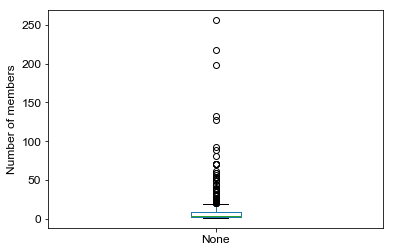

In [26]:
print('Median: ', np.median(top_clans))
ax = top_clans.plot.box()
ax.set_ylabel('Number of members')

In [27]:
def remove_diagonal(arr):
    return arr[~np.eye(arr.shape[0],dtype=bool)].reshape(arr.shape[0],-1)

def zero_diagonal(arr):
    arr[np.eye(arr.shape[0],dtype=bool)] = 0
    return arr

def flat_cosine_similarity(df):
    return remove_diagonal(cosine_similarity(df)).reshape(1, -1)[0]

In [28]:
def get_clan_cosine(clans, v):
    clan_cosine = []
    for clan_id, clan_pfams in clans.groupby('clan_id')['pfam_id']:
        clan_vecs = v.reindex(clan_pfams).dropna()
        if not len(clan_vecs):
            continue
        sim = flat_cosine_similarity(clan_vecs)
        clan_cosine.append(sim)
    return np.concatenate(clan_cosine)

In [29]:
clans_shuffled = clans[['pfam_id','clan_id']].copy()
np.random.seed(0)
np.random.shuffle(clans_shuffled['clan_id'].values)
clans_shuffled.head()

,pfam_id,clan_id
0,PF00001,CL0051
1,PF00002,CL0316
2,PF00003,CL0125
3,PF00004,CL0055
4,PF00005,CL0182


In [30]:
def boxplot_comparison(A, A_label, B, B_label, ylabel=None, yticks=None):
    summary = pd.DataFrame({
        'value': np.concatenate([A, B]), 
        'group': np.array([A_label]*len(A) + [B_label] * len(B))
    })

    with plt.style.context(('grayscale')):
        ax = summary.boxplot(by='group', figsize=(1.8, 3), grid=False, showfliers=False, widths=(0.3, 0.3))
    plt.suptitle('')
    plt.title('')
    ax.figure.set_facecolor('white')
    if yticks is not None:
        ax.set_yticks(yticks)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    print('Median:', summary.groupby('group')['value'].median())
    print('Wilcoxon:', stats.ranksums(A, B))
    return ax.figure

/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Median: group
Intra-clan    0.253119
Shuffled      0.160791
Name: value, dtype: float64
Wilcoxon: RanksumsResult(statistic=285.7625543513052, pvalue=0.0)


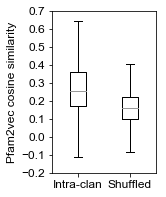

In [31]:
fig = boxplot_comparison(
    get_clan_cosine(clans, vecs),
    'Intra-clan',
    get_clan_cosine(clans_shuffled, vecs),
    'Shuffled',
    ylabel='Pfam2vec cosine similarity',
    yticks=np.arange(-0.2, 0.71, 0.1)
)
fig.savefig('../data/figures/paper/supplementary/S1a.pdf', bbox_inches='tight')

/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Median: group
Intra-clan   -0.000337
Shuffled      0.000300
Name: value, dtype: float64
Wilcoxon: RanksumsResult(statistic=-1.8537112742452204, pvalue=0.06378047788405565)


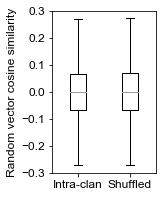

In [32]:
np.random.seed(0)
random_vecs = pd.DataFrame(np.random.rand(len(vecs), 100)*2-1, index=vecs.index)

fig = boxplot_comparison(
    get_clan_cosine(clans, random_vecs),
    'Intra-clan',
    get_clan_cosine(clans_shuffled, random_vecs),
    'Shuffled',
    ylabel='Random vector cosine similarity',
    yticks=np.arange(-0.3, 0.31, 0.1)
)
fig.savefig('../data/figures/paper/supplementary/S1b.pdf', bbox_inches='tight')

## Pfam clan prediction

In [33]:
from sklearn.model_selection import KFold
import keras
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer

NUM_CLANS = 10

def create_model():
    model = Sequential()
    model.add(Dense(NUM_CLANS, activation='softmax', input_dim=100))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[])
    return model

/Users/prihodad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
top_clan_pfams = clans[clans['clan_id'].apply(lambda c: c in top_clans[:NUM_CLANS])]['pfam_id']
idx = np.intersect1d(top_clan_pfams, vecs.index)
len(idx)

1276

In [35]:
samples = vecs.loc[idx]
samples.shape

(1276, 100)

In [36]:
responses_str = clans.set_index('pfam_id')['clan_id'].loc[idx]
encoder = LabelBinarizer()
responses = pd.DataFrame(encoder.fit_transform(responses_str), columns=encoder.classes_)
print(responses.shape)
responses[:5]

(1276, 10)


,CL0020,CL0023,CL0063,CL0123,CL0126,CL0159,CL0167,CL0186,CL0193,CL0236
0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [37]:
splitter = KFold(n_splits=5, shuffle=True, random_state=0)

scores = []
for train_idx, test_idx in splitter.split(samples.values, responses.values):
    X_train, X_test = samples.values[train_idx], samples.values[test_idx]
    y_train, y_test = responses.values[train_idx], responses.values[test_idx]
    model = create_model()
    # fitting the model
    model.fit(X_train, y_train, epochs=100, verbose=0)
    # predict the response
    pred = model.predict(X_test)
    aucs = metrics.roc_auc_score(y_test, pred, average=None)
    scores += [{'AUC': a, 'Class': c, 'Samples': int(sum(responses[c]))} for a,c in zip(aucs, responses.columns)]
    
scores = pd.DataFrame(scores).groupby('Class').mean().sort_values('Samples', ascending=False)
print(scores.mean())
scores

AUC          0.961742
Samples    127.600000
dtype: float64


,AUC,Samples
Class,,
CL0123,0.960988,247
CL0023,0.964263,212
CL0063,0.973280,195
CL0020,0.919951,120
CL0236,0.941815,120
CL0193,0.973001,88
CL0159,0.974290,81
CL0167,0.976703,76
CL0126,0.947082,71


# Description similarity

In [38]:
pfam_descriptions = pd.read_csv('../data/pfam/Pfam-A.clans.csv').set_index('pfam_id')['description']
print(len(pfam_descriptions))
pfam_descriptions = pfam_descriptions.loc[vecs.index].dropna()
print(len(pfam_descriptions))
pfam_descriptions.head()

16712
13311


pfam_id
PF00005                                      ABC transporter
PF13191                                    AAA ATPase domain
PF13555               P-loop containing region of AAA domain
PF13304    AAA domain, putative AbiEii toxin, Type IV TA ...
PF13401                                           AAA domain
Name: description, dtype: object

In [39]:
vecs_with_descr = vecs.loc[pfam_descriptions.index].dropna()
print(vecs_with_descr.shape)
vecs_with_descr.head()

(13311, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
pfam_id,,,,,,,,,,,,,,,,,,,,,
PF00005,0.045443,-0.035938,0.100785,0.040616,-0.164825,0.073102,0.058317,-0.108120,-0.069214,0.148570,...,-0.182994,0.114296,-0.118334,0.086235,0.099875,-0.009867,-0.118115,0.002825,0.037026,-0.107635
PF13191,0.127100,-0.062958,0.023303,0.051697,-0.137988,0.070571,0.050970,-0.177628,-0.072389,0.043156,...,-0.016578,-0.033136,-0.144379,0.066371,0.125671,0.019653,-0.074900,-0.017191,0.124659,-0.069454
PF13555,0.030957,-0.046982,0.070707,0.028994,-0.104818,0.042575,0.063894,-0.087249,-0.094825,0.191342,...,-0.172500,0.155366,-0.125272,0.087847,0.136480,-0.040163,-0.172234,-0.001175,-0.011556,-0.056780
PF13304,0.048468,-0.076121,0.077691,0.046967,-0.075462,0.050331,0.023607,-0.118182,-0.089822,0.211084,...,-0.216960,0.118862,-0.132330,0.125606,0.048127,-0.038995,-0.155338,0.034605,-0.060200,-0.006745
PF13401,0.183232,-0.107355,-0.019808,0.052991,-0.101377,0.005744,0.044784,-0.156965,-0.024766,-0.058936,...,-0.060474,-0.020538,-0.167633,0.111603,0.202157,-0.048945,-0.068455,-0.084468,0.020136,-0.046542


In [40]:
def get_most_similar(vecs):
    similarity = zero_diagonal(cosine_similarity(vecs))
    most_similar = pd.DataFrame({
        'pfam_id': vecs.index,
        'nearest_cosine_pfam_id': vecs.index[np.argmax(similarity, axis=1)],
        'cosine_sim': np.max(similarity, axis=1)
    })
    return most_similar[['pfam_id','nearest_cosine_pfam_id','cosine_sim']]

In [41]:
def sequence_similarity(row):
    return Levenshtein.ratio(row['desc'], row['nearest_cosine_desc'])

In [42]:
most_similar = get_most_similar(vecs_with_descr)
most_similar['desc'] = pfam_descriptions.loc[most_similar['pfam_id']].values
most_similar['nearest_cosine_desc'] = pfam_descriptions.loc[most_similar['nearest_cosine_pfam_id']].values
most_similar['descr_sim'] = most_similar.apply(sequence_similarity, axis=1)
most_similar = most_similar.sort_values('cosine_sim', ascending=False)
most_similar.head(10)

,pfam_id,nearest_cosine_pfam_id,cosine_sim,desc,nearest_cosine_desc,descr_sim
71,PF00165,PF12833,0.996721,Bacterial regulatory helix-turn-helix proteins...,Helix-turn-helix domain,0.463415
68,PF12833,PF00165,0.996721,Helix-turn-helix domain,Bacterial regulatory helix-turn-helix proteins...,0.463415
138,PF07715,PF00593,0.995982,TonB-dependent Receptor Plug Domain,TonB dependent receptor,0.724138
152,PF00593,PF07715,0.995982,TonB dependent receptor,TonB-dependent Receptor Plug Domain,0.724138
24,PF00126,PF03466,0.994960,"Bacterial regulatory helix-turn-helix protein,...",LysR substrate binding domain,0.275862
26,PF03466,PF00126,0.994960,LysR substrate binding domain,"Bacterial regulatory helix-turn-helix protein,...",0.275862
1185,PF00081,PF02777,0.993994,"Iron/manganese superoxide dismutases, alpha-ha...","Iron/manganese superoxide dismutases, C-termin...",0.867257
1171,PF02777,PF00081,0.993994,"Iron/manganese superoxide dismutases, C-termin...","Iron/manganese superoxide dismutases, alpha-ha...",0.867257
1177,PF09285,PF08207,0.993679,"Elongation factor P, C-terminal",Elongation factor P (EF-P) KOW-like domain,0.684932
1174,PF08207,PF09285,0.993679,Elongation factor P (EF-P) KOW-like domain,"Elongation factor P, C-terminal",0.684932


In [43]:
known_similar = most_similar[most_similar['desc'].apply(lambda desc: 'unknown' not in desc)]
known_similar = known_similar[known_similar['nearest_cosine_desc'].apply(lambda desc: 'unknown' not in desc)]
print(known_similar.shape)
known_similar.head()

(8839, 6)


,pfam_id,nearest_cosine_pfam_id,cosine_sim,desc,nearest_cosine_desc,descr_sim
71,PF00165,PF12833,0.996721,Bacterial regulatory helix-turn-helix proteins...,Helix-turn-helix domain,0.463415
68,PF12833,PF00165,0.996721,Helix-turn-helix domain,Bacterial regulatory helix-turn-helix proteins...,0.463415
138,PF07715,PF00593,0.995982,TonB-dependent Receptor Plug Domain,TonB dependent receptor,0.724138
152,PF00593,PF07715,0.995982,TonB dependent receptor,TonB-dependent Receptor Plug Domain,0.724138
24,PF00126,PF03466,0.994960,"Bacterial regulatory helix-turn-helix protein,...",LysR substrate binding domain,0.275862


In [44]:
known_similar[['pfam_id','desc','nearest_cosine_pfam_id','nearest_cosine_desc','cosine_sim']].to_csv('../data/figures/paper/supplementary/1.csv', index=False)

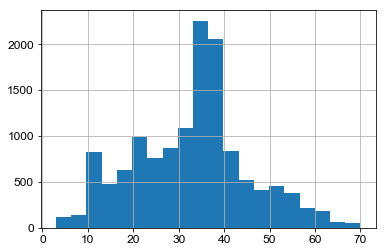

In [45]:
pfam_descriptions.apply(len).hist(bins=20)

In [46]:
shuffle_idx = list(range(len(known_similar)))
np.random.seed(0)
np.random.shuffle(shuffle_idx)

shuffled_similar = known_similar[['pfam_id','desc']].copy()
shuffled_similar['nearest_cosine_pfam_id'] = known_similar['nearest_cosine_pfam_id'].iloc[shuffle_idx].values
shuffled_similar['nearest_cosine_desc'] = known_similar['nearest_cosine_desc'].iloc[shuffle_idx].values
shuffled_similar['descr_sim'] = shuffled_similar.apply(sequence_similarity, axis=1)
shuffled_similar.head()

,pfam_id,desc,nearest_cosine_pfam_id,nearest_cosine_desc,descr_sim
71,PF00165,Bacterial regulatory helix-turn-helix proteins...,PF02316,Mu DNA-binding domain,0.225000
68,PF12833,Helix-turn-helix domain,PF04582,Reovirus sigma C capsid protein,0.333333
138,PF07715,TonB-dependent Receptor Plug Domain,PF00672,HAMP domain,0.304348
152,PF00593,TonB dependent receptor,PF01956,Integral membrane protein DUF106,0.290909
24,PF00126,"Bacterial regulatory helix-turn-helix protein,...",PF00752,XPG N-terminal domain,0.278481


In [47]:
unknown_similar = most_similar[most_similar['desc'].apply(lambda desc: 'unknown' in desc)]
unknown_similar = unknown_similar[unknown_similar['nearest_cosine_desc'].apply(lambda desc: 'unknown' not in desc)]
print(unknown_similar.shape)
unknown_similar = unknown_similar.drop('descr_sim', axis=1)
unknown_similar.head()

(2170, 6)


,pfam_id,nearest_cosine_pfam_id,cosine_sim,desc,nearest_cosine_desc
3291,PF11842,PF08497,0.987364,Domain of unknown function (DUF3362),Radical SAM N-terminal
2348,PF06974,PF03007,0.983262,Protein of unknown function (DUF1298),Wax ester synthase-like Acyl-CoA acyltransfera...
2234,PF08340,PF03755,0.980625,Domain of unknown function (DUF1732),"YicC-like family, N-terminal region"
2695,PF11898,PF07717,0.976964,Domain of unknown function (DUF3418),Oligonucleotide/oligosaccharide-binding (OB)-fold
7113,PF14232,PF14231,0.966267,Domain of unknown function (DUF4334),GXWXG protein


In [48]:
unknown_similar[['pfam_id','desc','nearest_cosine_pfam_id','nearest_cosine_desc','cosine_sim']].to_csv('../data/figures/paper/supplementary/2.csv', index=False)

Median: group
Nearest     0.340426
Shuffled    0.300000
Name: value, dtype: float64
Wilcoxon: RanksumsResult(statistic=31.410559745746248, pvalue=1.4517966043018098e-216)


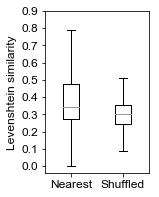

In [49]:
fig = boxplot_comparison(
    known_similar['descr_sim'],
    'Nearest',
    shuffled_similar['descr_sim'],
    'Shuffled',
    ylabel='Levenshtein similarity',
    yticks=np.arange(0, 0.91, 0.1)
)
fig.savefig('../data/figures/paper/supplementary/S1c.pdf', bbox_inches='tight')

# C- and N- terminal domains

In [376]:
def get_terminals(descriptions, kind):
    ANY_terminals = pfam_descriptions[pfam_descriptions.apply(lambda d: kind+'-terminal' in d or kind+' terminal' in d)].reset_index()
    print(len(ANY_terminals))
    return ANY_terminals.rename(columns={'pfam_id': kind+'_pfam_id', 'description': kind+'_descr'})

In [377]:
C_terminals = get_terminals(pfam_descriptions, 'C')
C_terminals.head()

526


,C_pfam_id,C_descr
0,PF00271,Helicase conserved C-terminal domain
1,PF00486,"Transcriptional regulatory protein, C terminal"
2,PF01262,"Alanine dehydrogenase/PNT, C-terminal domain"
3,PF13193,AMP-binding enzyme C-terminal domain
4,PF02775,"Thiamine pyrophosphate enzyme, C-terminal TPP ..."


In [378]:
N_terminals = get_terminals(pfam_descriptions, 'N')
N_terminals['C_descr'] = N_terminals['N_descr'].apply(lambda d: d.replace('N-terminal', 'C-terminal').replace('N terminal', 'C terminal'))
N_terminals.head()

480


,N_pfam_id,N_descr,C_descr
0,PF02463,RecF/RecN/SMC N terminal domain,RecF/RecN/SMC C terminal domain
1,PF00108,"Thiolase, N-terminal domain","Thiolase, C-terminal domain"
2,PF02771,"Acyl-CoA dehydrogenase, N-terminal domain","Acyl-CoA dehydrogenase, C-terminal domain"
3,PF00109,"Beta-ketoacyl synthase, N-terminal domain","Beta-ketoacyl synthase, C-terminal domain"
4,PF01325,"Iron dependent repressor, N-terminal DNA bindi...","Iron dependent repressor, C-terminal DNA bindi..."


In [379]:
C_terminals[C_terminals['C_descr'].apply(lambda d: 'Cytochrome' in d)]

,C_pfam_id,C_descr
137,PF16327,Cytochrome c-type biogenesis protein CcmF C-te...
165,PF00032,Cytochrome b(C-terminal)/b6/petD


In [380]:
N_terminals[N_terminals['N_descr'].apply(lambda d: 'Cytochrome' in d)]

,N_pfam_id,N_descr,C_descr
102,PF13631,Cytochrome b(N-terminal)/b6/petB,Cytochrome b(C-terminal)/b6/petB
366,PF09786,"Cytochrome B561, N terminal","Cytochrome B561, C terminal"


In [381]:
terminals = N_terminals.drop_duplicates(subset=['C_descr']).merge(C_terminals, on='C_descr')
print(len(terminals))
terminals.head()

85


,N_pfam_id,N_descr,C_descr,C_pfam_id
0,PF00108,"Thiolase, N-terminal domain","Thiolase, C-terminal domain",PF02803
1,PF02771,"Acyl-CoA dehydrogenase, N-terminal domain","Acyl-CoA dehydrogenase, C-terminal domain",PF00441
2,PF02771,"Acyl-CoA dehydrogenase, N-terminal domain","Acyl-CoA dehydrogenase, C-terminal domain",PF08028
3,PF00109,"Beta-ketoacyl synthase, N-terminal domain","Beta-ketoacyl synthase, C-terminal domain",PF02801
4,PF13417,"Glutathione S-transferase, N-terminal domain","Glutathione S-transferase, C-terminal domain",PF13410


In [390]:
CN_matches = []
CN_diffs = []
for i, terminal in terminals.iterrows():
    C_to_N_vector = vecs.loc[terminal['N_pfam_id']] - vecs.loc[terminal['C_pfam_id']]
    CN_diffs.append(C_to_N_vector)
    C_translated_vecs = vecs.loc[terminals['C_pfam_id']] + C_to_N_vector*5
    C_translated_nearest = get_most_similar(C_translated_vecs)
    CN_matches.append(sum(C_translated_nearest['nearest_cosine_pfam_id'] == terminals['N_pfam_id']))
    print(C_translated_nearest.head())
    break
CN_matches = pd.Series(CN_matches)
sum(CN_matches != 0)

   pfam_id nearest_cosine_pfam_id  cosine_sim
0  PF02803                PF02801    0.967427
1  PF00441                PF08028    0.994966
2  PF08028                PF00441    0.994966
3  PF02801                PF02803    0.967427
4  PF13410                PF00043    0.993365


0

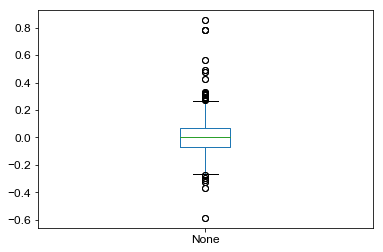

In [383]:
pd.Series(flat_cosine_similarity(CN_diffs)).plot.box()

# Pfam similarity

## Per-pfam BGC probability

In [227]:
pos = pd.read_csv('../data/training/positive/CF_bgcs.csv')['pfam_id']
len(pos)

57521

In [228]:
pfam_probs = pd.DataFrame()
pfam_probs['bgc_count'] = pos.value_counts()
pfam_probs['bgc_prob'] = pfam_probs['bgc_count'] / pfam_probs['bgc_count'].sum()
pfam_probs = pfam_probs.sort_values(by='bgc_prob', ascending=False)
pfam_probs.index.name = 'pfam_id'

In [237]:
top_50percent = pfam_probs['bgc_prob'].quantile(0.50)
top_50percent

3.476991011978234e-05

In [238]:
pfam_probs['prob_class'] = pfam_probs['bgc_prob'].apply(lambda prob: 'BGC' if prob > top_50percent else '- non-BGC -')
pfam_probs.head()

,bgc_count,bgc_prob,prob_class
pfam_id,,,
PF00550,1134,0.019715,BGC
PF00106,954,0.016585,BGC
PF01370,881,0.015316,BGC
PF08659,878,0.015264,BGC
PF00109,804,0.013978,BGC


In [240]:
pfam_probs.to_csv('../data/features/bgc_prob.csv', index=True, header=True)
pfam_probs['prob_class'].value_counts()

- non-BGC -    3130
BGC            1804
Name: prob_class, dtype: int64

In [241]:
BIO_PFAM_IDS = ["PF00109", "PF02801", "PF08659", "PF00378", "PF08541", "PF08545", "PF02803", "PF00108",
    "PF02706", "PF03364", "PF08990", "PF00501", "PF00668", "PF08415", "PF00975", "PF03061", "PF00432", "PF00494", "PF03936",
    "PF01397", "PF00432", "PF04275", "PF00348", "PF02401", "PF04551", "PF00368", "PF00534", "PF00535", "PF02922", "PF01041",
    "PF00128", "PF00908", "PF02719", "PF04321", "PF01943", "PF02806", "PF02350", "PF02397", "PF04932", "PF01075", "PF00953",
    "PF01050", "PF03033", "PF01501", "PF05159", "PF04101", "PF02563", "PF08437", "PF02585", "PF01721", "PF02052", "PF02674",
    "PF03515", "PF04369", "PF08109", "PF08129", "PF09221", "PF09683", "PF10439", "PF11420", "PF11632", "PF11758", "PF12173",
    "PF04738", "PF04737", "PF04604", "PF05147", "PF08109", "PF08129", "PF08130", "PF00155", "PF00202", "PF00702", "PF06339",
    "PF04183", "PF10331", "PF03756", "PF00106", "PF01370", "PF00107", "PF08240", "PF00441", "PF02770", "PF02771", "PF08028",
    "PF01408", "PF02894", "PF00984", "PF00725", "PF03720", "PF03721", "PF07993", "PF02737", "PF00903", "PF00037", "PF04055",
    "PF00171", "PF00067", "PF01266", "PF01118", "PF02668", "PF00248", "PF01494", "PF01593", "PF03992", "PF00355", "PF01243",
    "PF00384", "PF01488", "PF00857", "PF04879", "PF08241", "PF08242", "PF00698", "PF00483", "PF00561", "PF00583", "PF01636",
    "PF01039", "PF00288", "PF00289", "PF02786", "PF01757", "PF02785", "PF02409", "PF01553", "PF02348", "PF00891", "PF01596",
    "PF04820", "PF02522", "PF08484", "PF08421"]

## Interpro properties

In [244]:
interpro = pd.read_csv('../data/features/interpro/interpro_props.csv').set_index('pfam_id')
del interpro['classes']
interpro.head()

,integral component of membrane,oxidation-reduction process,DNA binding,membrane,ATP binding,nucleus,"regulation of transcription, DNA-templated",cytoplasm,extracellular region,G-protein coupled receptor signaling pathway,...,pathogenesis,carbohydrate metabolic process,protein binding,structural molecule activity,DNA repair,catalytic activity,calcium ion binding,metal ion binding,integral component of plasma membrane,"transcription, DNA-templated"
pfam_id,,,,,,,,,,,,,,,,,,,,,
PF00001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PF00002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PF00003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PF00004,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PF00005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Per-pfam BGC probability prediction

In [245]:
from sklearn import linear_model, neural_network
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [261]:
common_probs = pfam_probs['bgc_prob']

### Predicting using pfam2vec

In [266]:
idx = np.intersect1d(common_probs.index, vecs.index)
X = vecs.loc[idx]
y = common_probs.loc[idx]

folds = 5
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X, y, cv=folds, scoring='r2')

sum(scores) / folds

0.13377462661873155

### Predicting using random vectors

In [267]:
idx = np.intersect1d(common_probs.index, vecs.index)
X = np.random.rand(len(idx), vecs.shape[1])
y = common_probs.loc[idx]

folds = 5
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X, y, cv=folds, scoring='r2')

sum(scores) / folds

-0.06467169605816517

# Biosynthetic domain prediction

In [270]:
idx = np.concatenate([vecs.sample(500).index, BIO_PFAM_IDS])
X = vecs.loc[idx].dropna()
y = np.array([pfam_id in BIO_PFAM_IDS for pfam_id in X.index])

In [275]:
folds = 5
regr = linear_model.LogisticRegression()
recalls = cross_val_score(regr, X, y, cv=folds, scoring='recall')
precisions = cross_val_score(regr, X, y, cv=folds, scoring='precision')

print('Mean precision: {}, mean recall: {}'.format(sum(precisions) / folds, sum(recalls) / folds))

Mean precision: 0.7998249299719887, mean recall: 0.3313390313390313


# Feature correlation

In [276]:
features = vecs.join(common_probs).join(interpro)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,pathogenesis,carbohydrate metabolic process,protein binding,structural molecule activity,DNA repair,catalytic activity,calcium ion binding,metal ion binding,integral component of plasma membrane,"transcription, DNA-templated"
pfam_id,,,,,,,,,,,,,,,,,,,,,
</s>,0.143333,0.158255,-0.137158,-0.117384,0.048936,0.108183,0.033691,0.007568,-0.129039,0.079442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PF00005,0.045443,-0.035938,0.100785,0.040616,-0.164825,0.073102,0.058317,-0.108120,-0.069214,0.148570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PF13191,0.127100,-0.062958,0.023303,0.051697,-0.137988,0.070571,0.050970,-0.177628,-0.072389,0.043156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PF13555,0.030957,-0.046982,0.070707,0.028994,-0.104818,0.042575,0.063894,-0.087249,-0.094825,0.191342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PF13304,0.048468,-0.076121,0.077691,0.046967,-0.075462,0.050331,0.023607,-0.118182,-0.089822,0.211084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
corr = features.corr().drop(vecs.columns, axis=1)
corr.head()

,bgc_prob,integral component of membrane,oxidation-reduction process,DNA binding,membrane,ATP binding,nucleus,"regulation of transcription, DNA-templated",cytoplasm,extracellular region,...,pathogenesis,carbohydrate metabolic process,protein binding,structural molecule activity,DNA repair,catalytic activity,calcium ion binding,metal ion binding,integral component of plasma membrane,"transcription, DNA-templated"
0,-0.084947,-0.066950,-0.075948,0.008874,0.002080,-0.048619,0.023148,-0.024388,-0.024217,0.006110,...,0.021788,0.019268,0.054582,0.025414,0.013102,-0.025519,0.098422,0.024717,0.012572,0.013284
1,-0.018219,0.010758,-0.058439,0.024717,-0.020067,-0.012122,0.048512,0.043901,-0.007619,0.010192,...,0.021497,-0.034160,-0.034929,0.007738,-0.075930,-0.015283,-0.035639,-0.020755,-0.017079,-0.009434
2,-0.131333,0.033761,-0.024364,-0.032770,0.023950,0.009223,-0.011700,0.013997,-0.018705,-0.003890,...,-0.005474,-0.046980,0.000329,-0.020493,0.010679,-0.018226,-0.014721,0.019001,0.033100,-0.004387
3,-0.058432,-0.043526,-0.025316,0.048230,-0.005250,-0.011060,0.015020,0.035165,0.007849,-0.011777,...,0.020242,0.020399,0.001811,0.040463,-0.005909,-0.018493,0.027775,0.017668,0.010488,0.027197
4,-0.044952,0.062708,0.044515,-0.050400,0.035624,-0.085345,0.008267,0.040082,-0.005790,0.024704,...,0.023213,0.053963,-0.041676,0.017305,-0.017972,0.031229,-0.002592,-0.008991,-0.000410,-0.021261


In [278]:
import seaborn as sns

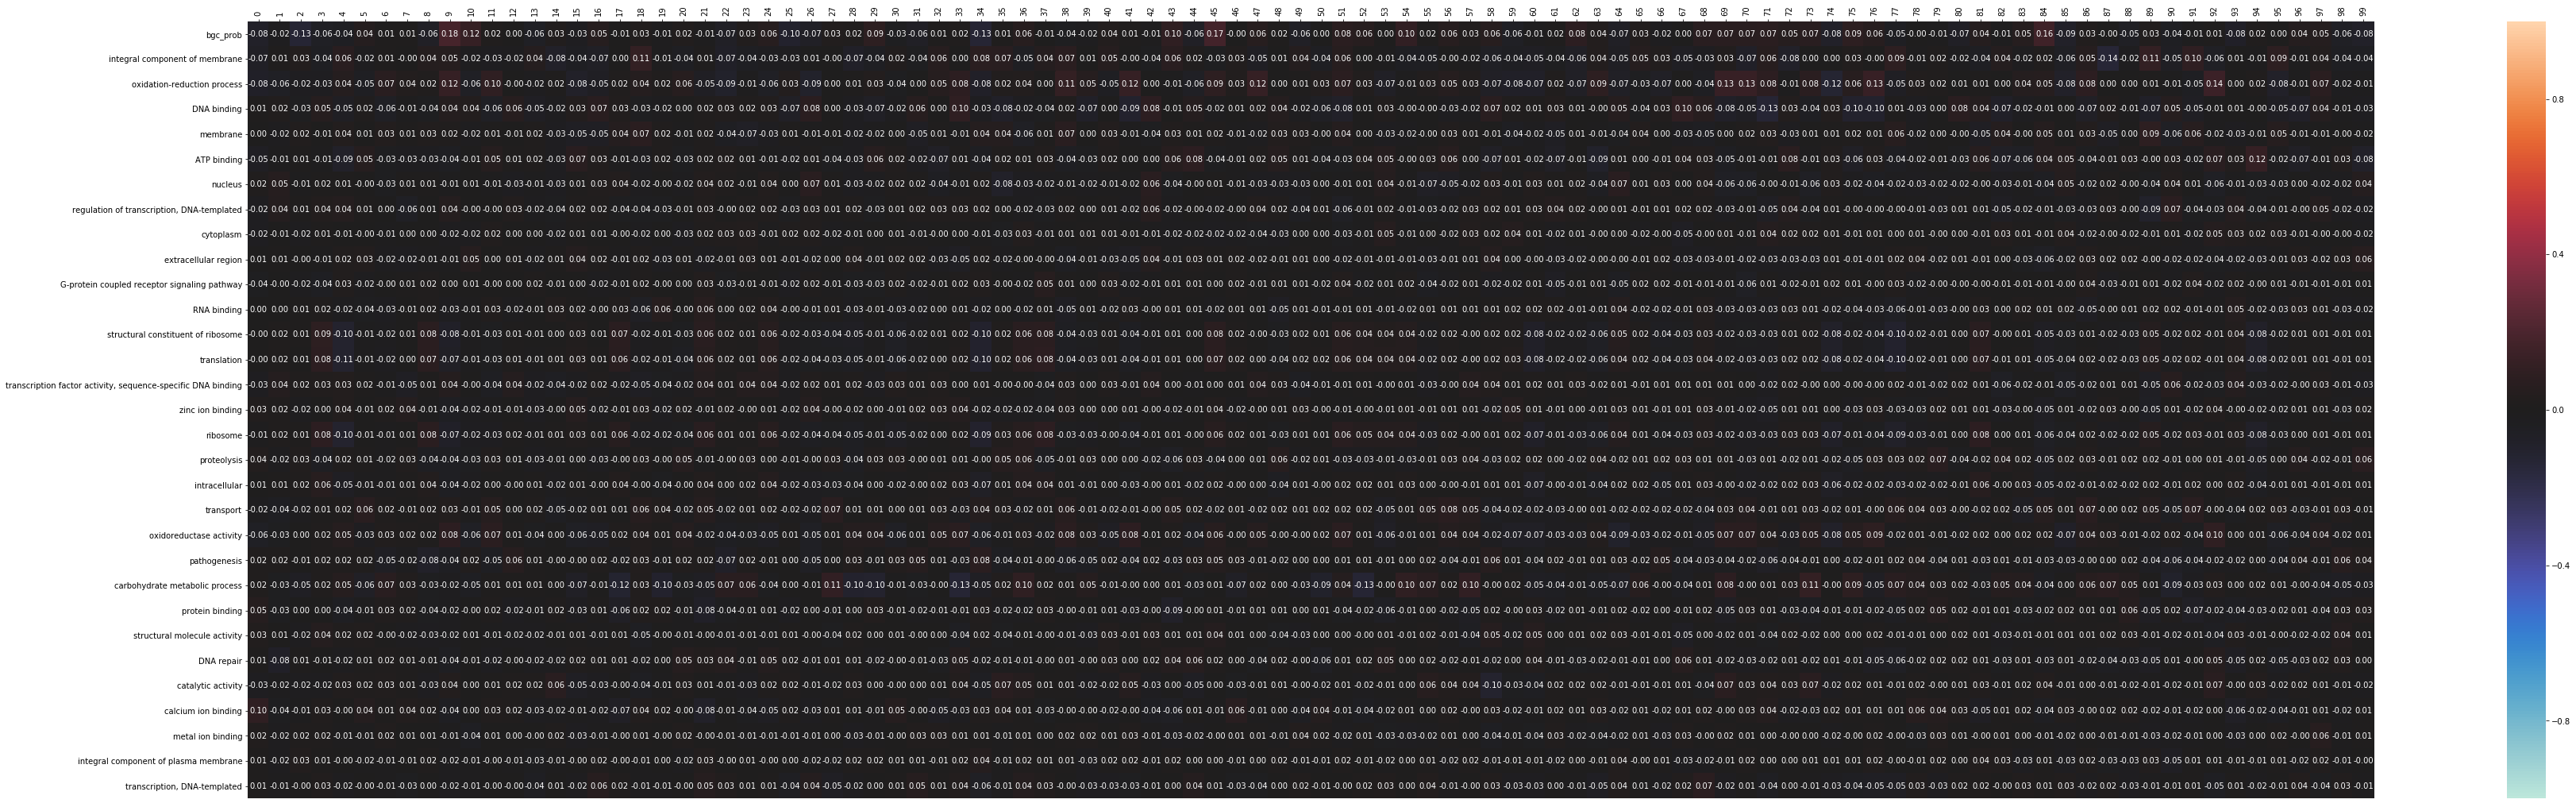

In [279]:
fig, ax = plt.subplots(1,1, figsize=(60, 18))
sns.heatmap(corr.loc[vecs.columns].transpose(), annot=True, ax=ax, fmt='.2f', vmin=-1, vmax=1, center=0)
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

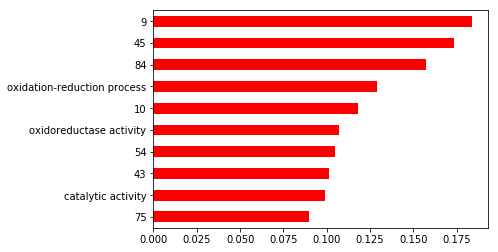

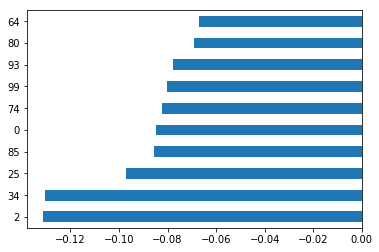

In [281]:
corr['bgc_prob'][corr['bgc_prob'] < 1].sort_values()[-10:].plot.barh(color='red')
plt.show()
corr['bgc_prob'].sort_values()[0:10].plot.barh()
plt.show()

/Users/prihodad/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


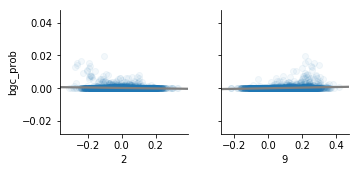

In [282]:
col = 'bgc_prob'
pos_corr = corr[col].loc[vecs.columns].idxmax()
neg_corr = corr[col].loc[vecs.columns].idxmin()
sns.pairplot(
    features,
    x_vars=[neg_corr, pos_corr], 
    y_vars=[col], 
    size=2.5, 
    kind="reg", 
    plot_kws={'line_kws':{'color':'grey'}, 'scatter_kws': {'alpha': 0.05}}
)

/Users/prihodad/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


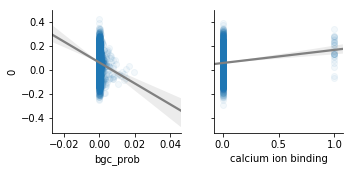

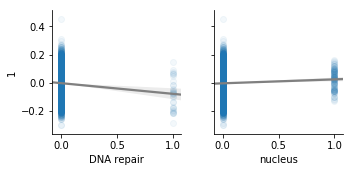

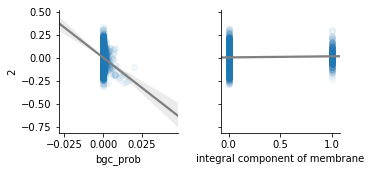

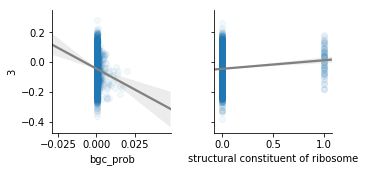

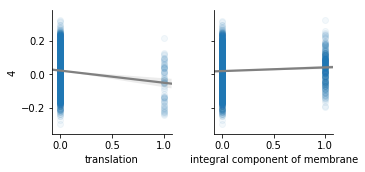

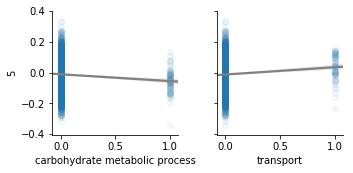

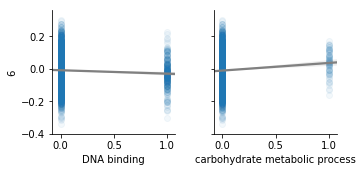

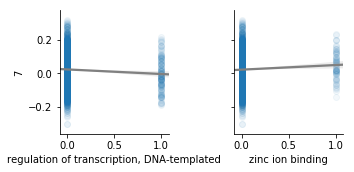

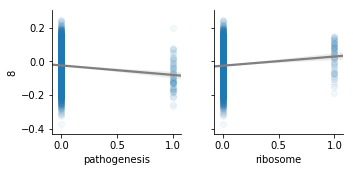

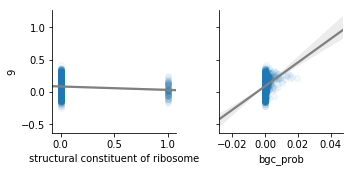

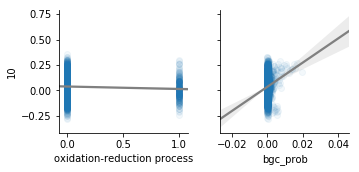

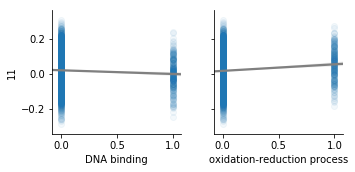

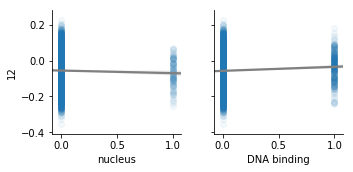

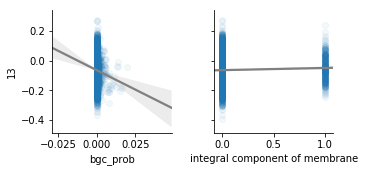

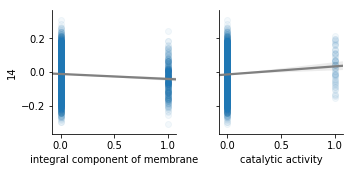

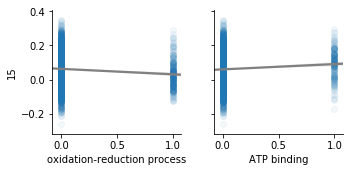

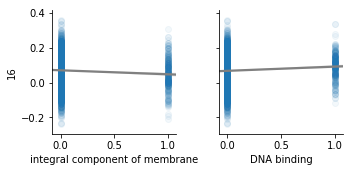

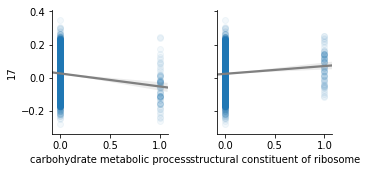

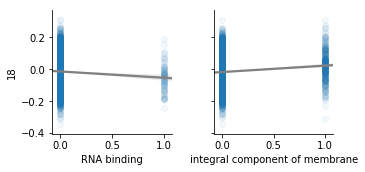

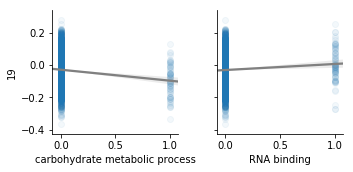

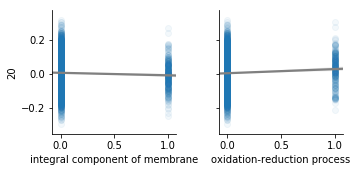

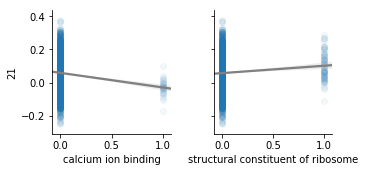

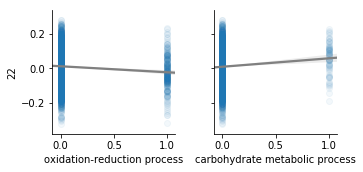

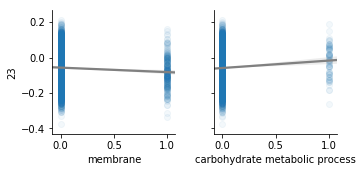

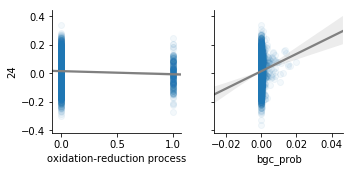

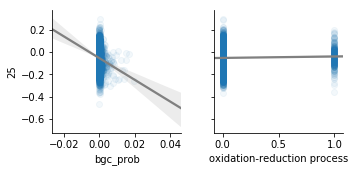

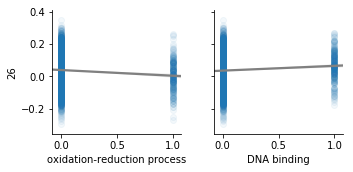

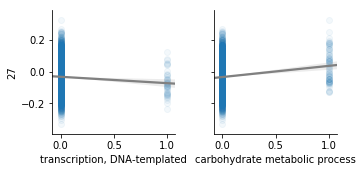

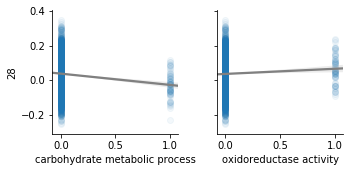

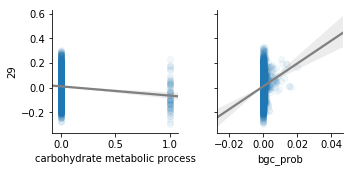

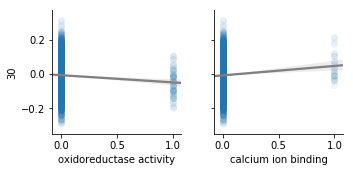

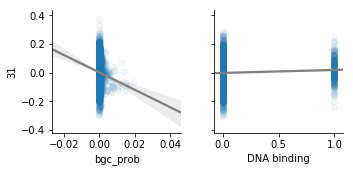

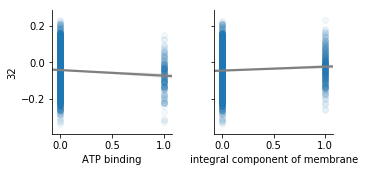

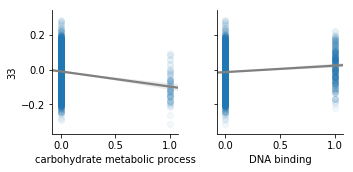

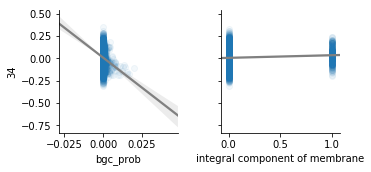

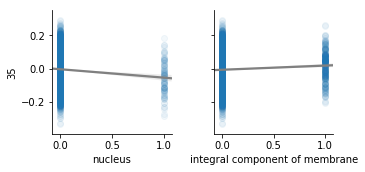

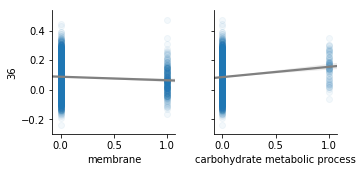

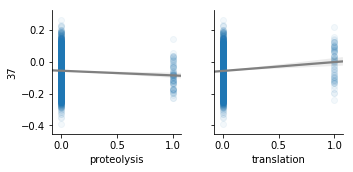

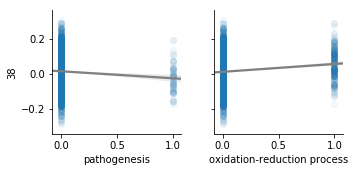

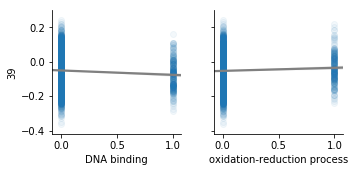

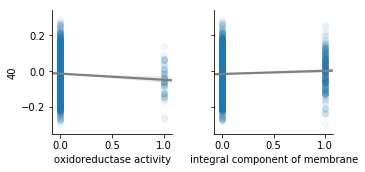

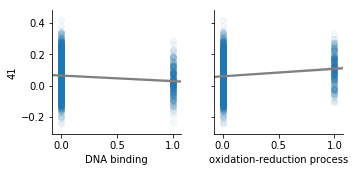

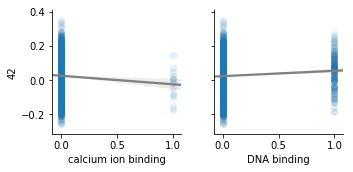

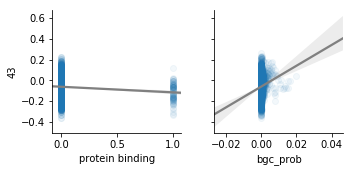

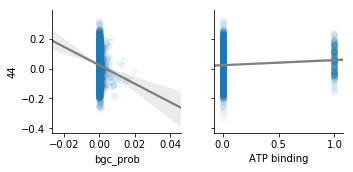

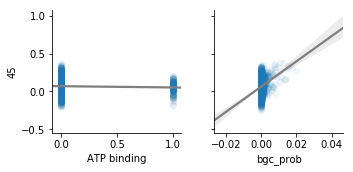

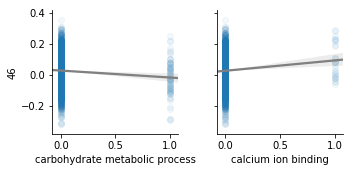

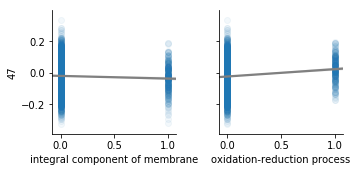

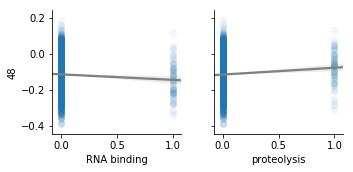

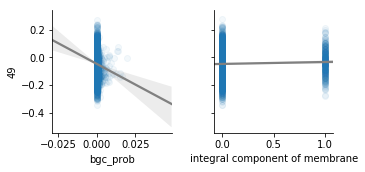

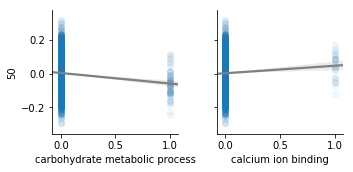

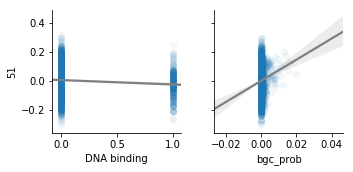

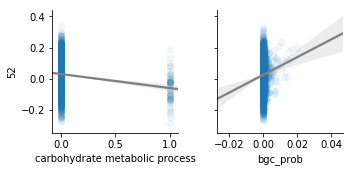

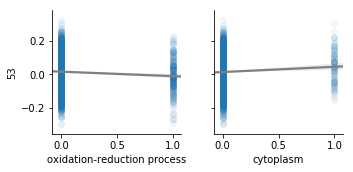

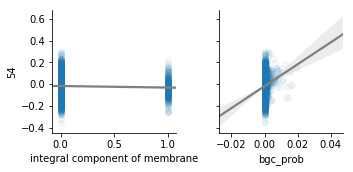

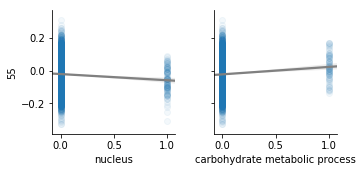

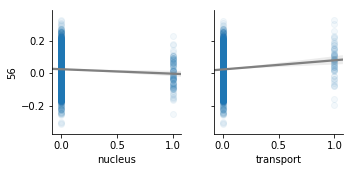

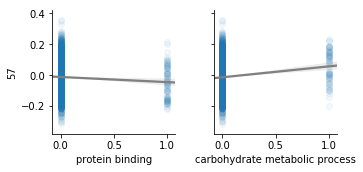

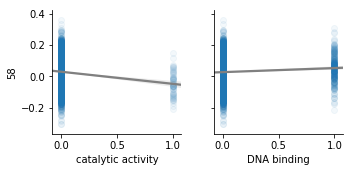

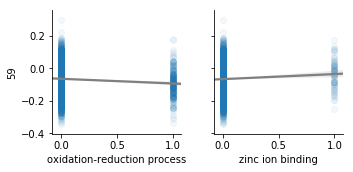

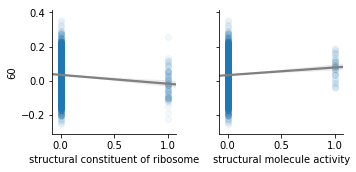

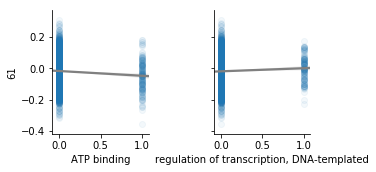

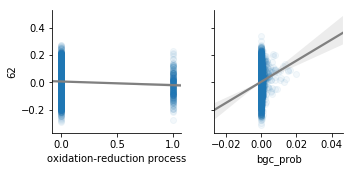

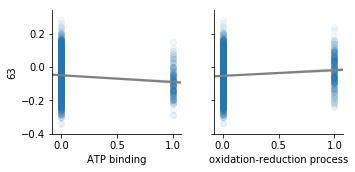

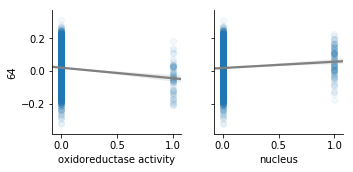

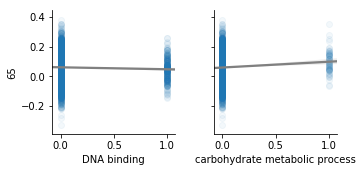

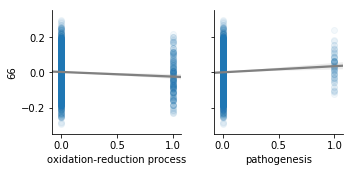

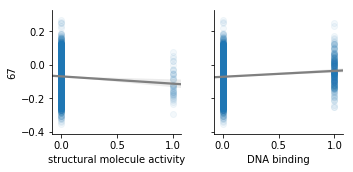

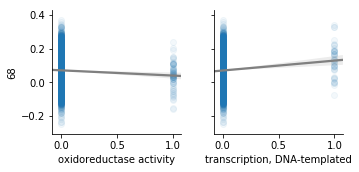

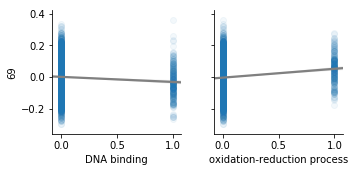

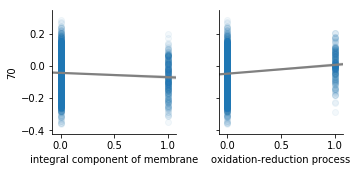

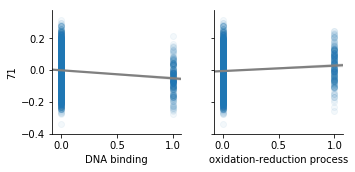

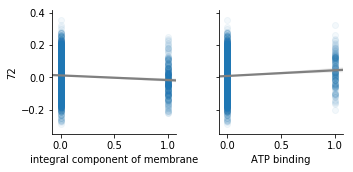

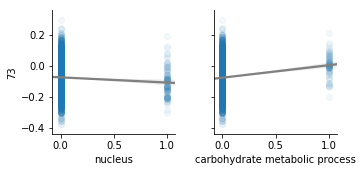

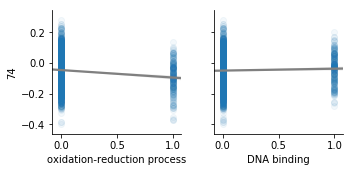

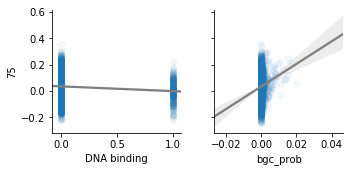

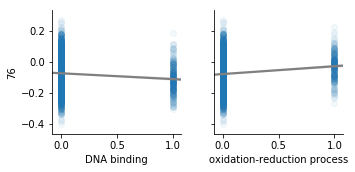

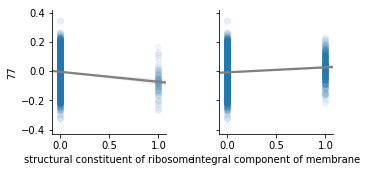

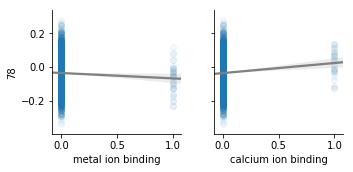

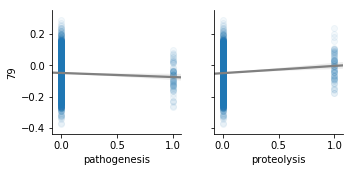

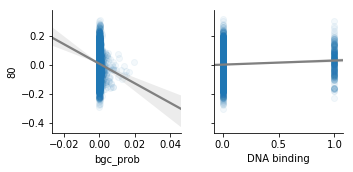

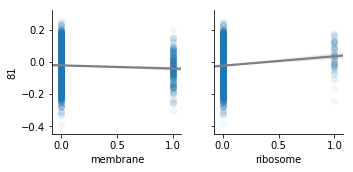

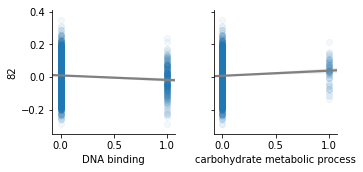

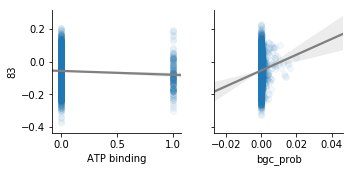

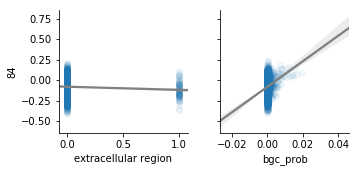

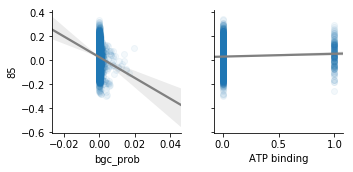

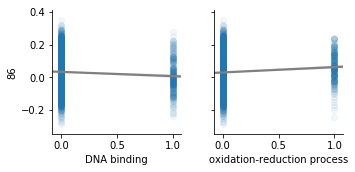

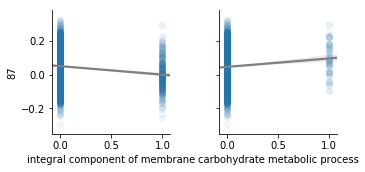

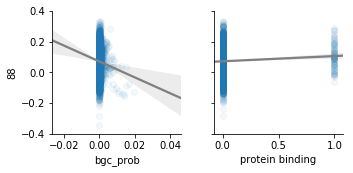

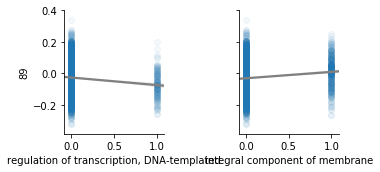

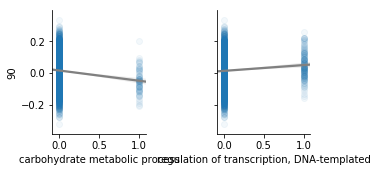

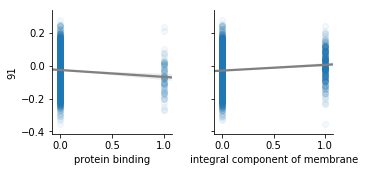

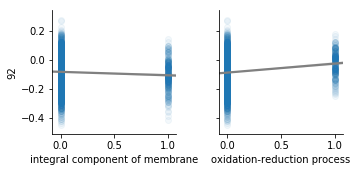

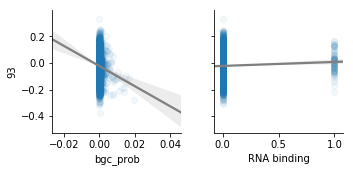

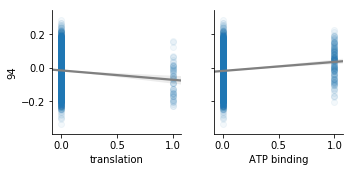

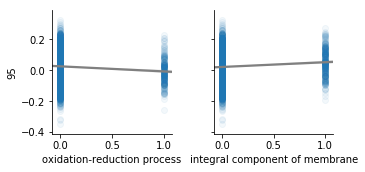

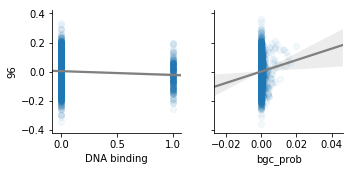

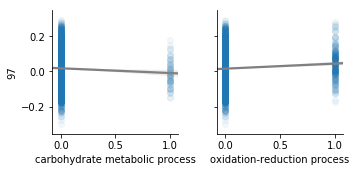

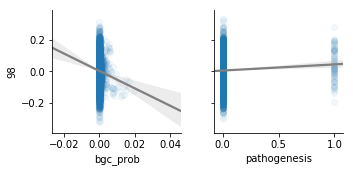

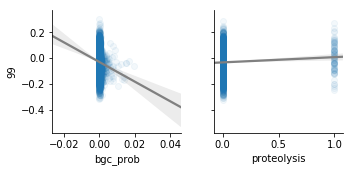

In [283]:
for col in vecs.columns:
    pos_corr = corr.transpose()[col].idxmax()
    neg_corr = corr.transpose()[col].idxmin()
    try:
        sns.pairplot(
            features,
            x_vars=[neg_corr, pos_corr], 
            y_vars=[col], 
            size=2.5, 
            kind="reg", 
            plot_kws={'line_kws':{'color':'grey'}, 'scatter_kws': {'alpha': 0.05}}
        )
        plt.show()
    except:
        print('Cannot print', col)